In [1]:
pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart 

In [2]:
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

2024-03-29 01:41:11.480165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 01:41:11.480214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 01:41:11.481608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_dir = "/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets


/kaggle/input/handwritten-marathi-character-augmented-dataset/Alphabets/C5/C5_61.jpg


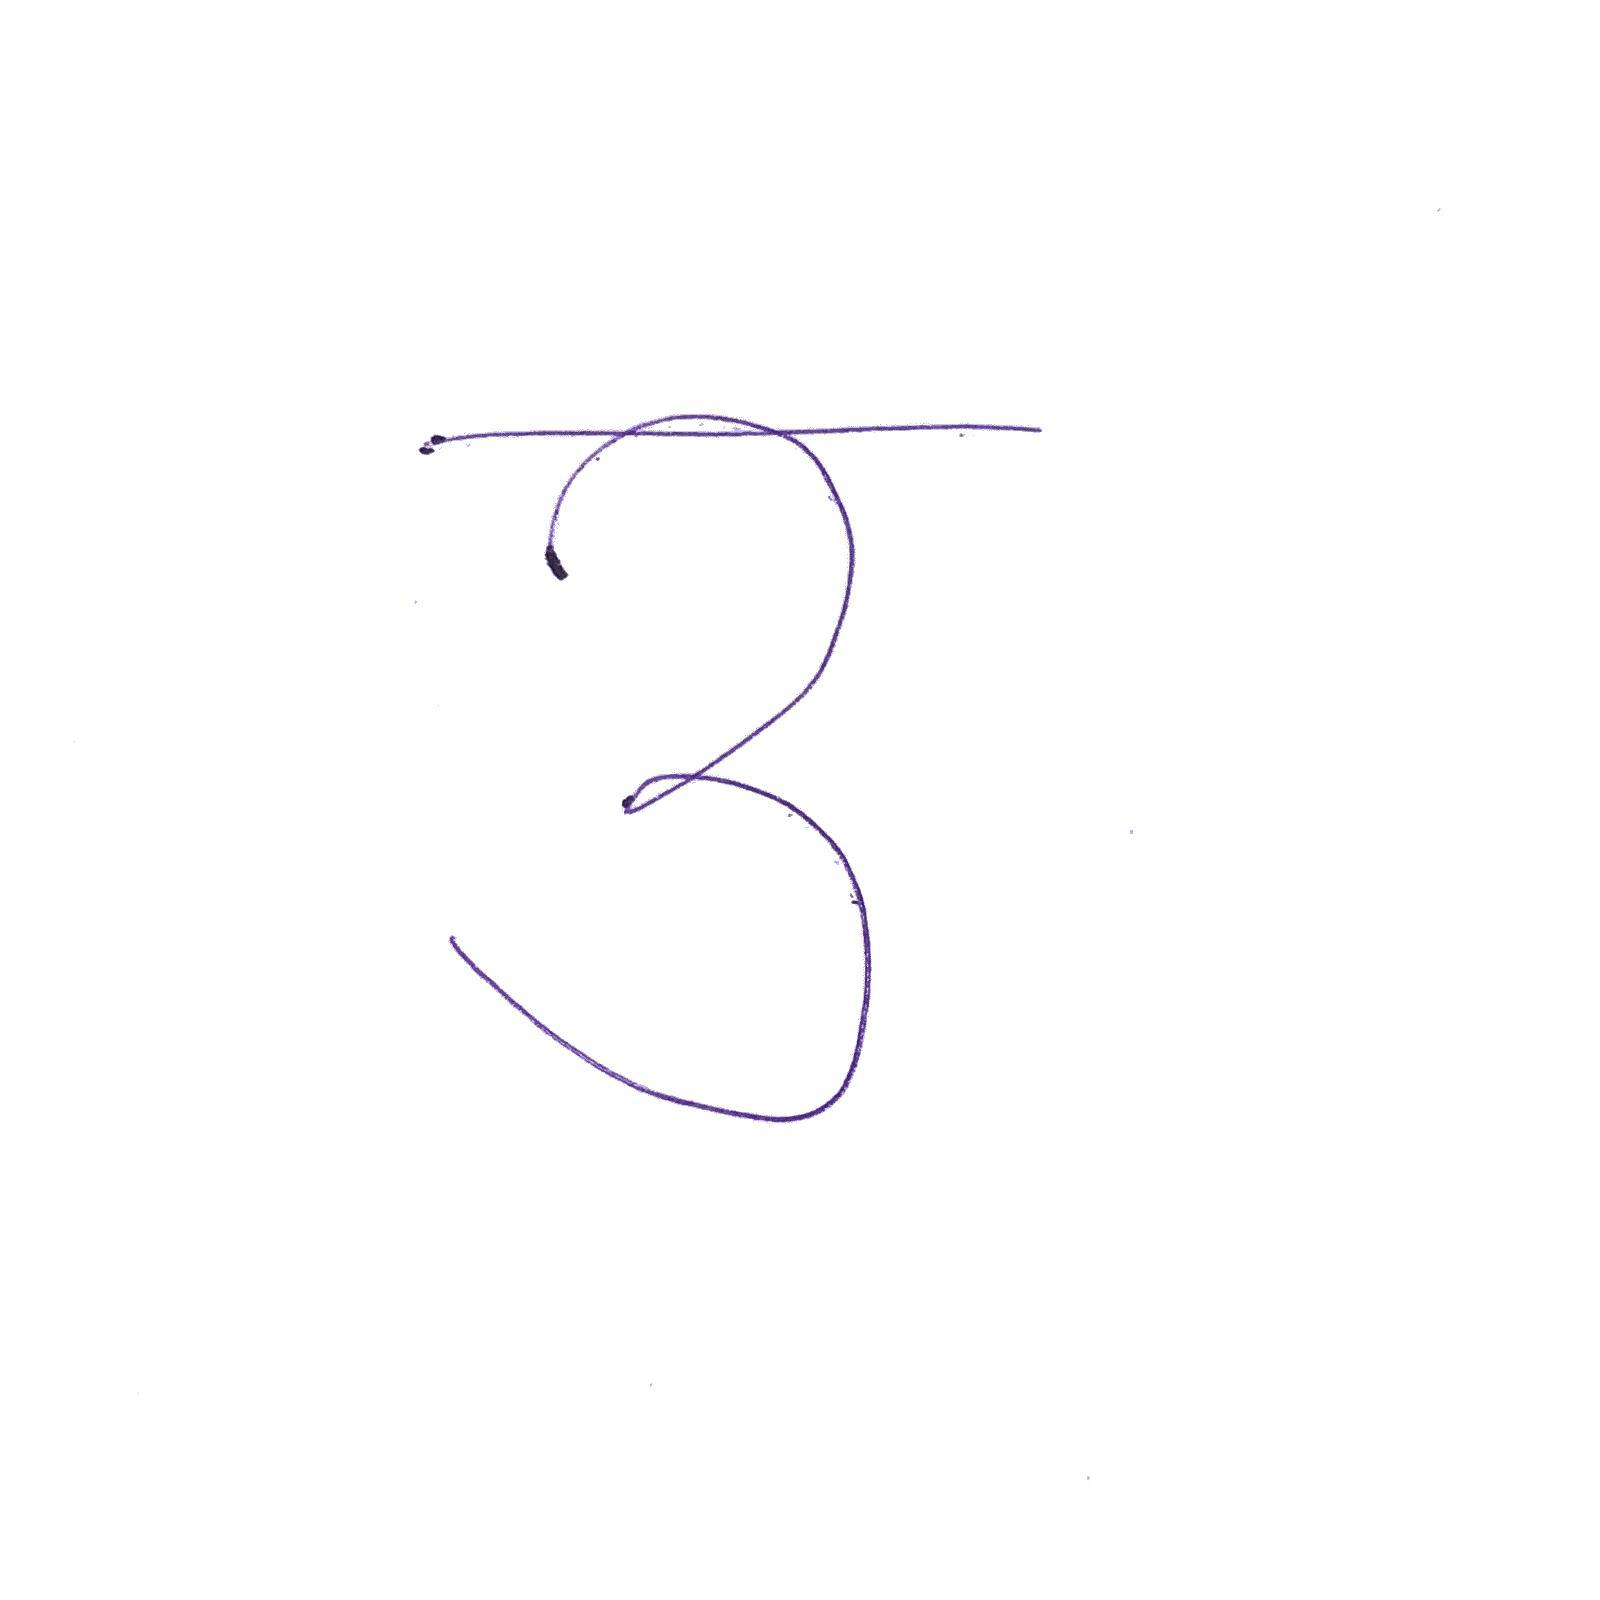

In [4]:
ch1 = list(data_dir.glob('C5/*'))
print(ch1[0])
PIL.Image.open(str(ch1[0]))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height,img_width=224,224
batch_size = 32

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    channel_shift_range=50,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,    
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)


# Prepare training dataset with data augmentation
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Prepare validation dataset without data augmentation
val_ds = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)



Found 23040 images belonging to 48 classes.
Found 5760 images belonging to 48 classes.


In [6]:
class_indices = train_ds.class_indices
class_names = {v: k for k, v in class_indices.items()}
print(class_names)

{0: 'C1', 1: 'C10', 2: 'C11', 3: 'C12', 4: 'C13', 5: 'C14', 6: 'C15', 7: 'C16', 8: 'C17', 9: 'C18', 10: 'C19', 11: 'C2', 12: 'C20', 13: 'C21', 14: 'C22', 15: 'C23', 16: 'C24', 17: 'C25', 18: 'C26', 19: 'C27', 20: 'C28', 21: 'C29', 22: 'C3', 23: 'C30', 24: 'C31', 25: 'C32', 26: 'C33', 27: 'C34', 28: 'C35', 29: 'C36', 30: 'C37', 31: 'C38', 32: 'C39', 33: 'C4', 34: 'C40', 35: 'C41', 36: 'C42', 37: 'C43', 38: 'C44', 39: 'C45', 40: 'C46', 41: 'C47', 42: 'C48', 43: 'C5', 44: 'C6', 45: 'C7', 46: 'C8', 47: 'C9'}


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


# Load VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(train_ds.class_indices), activation="softmax")
])


model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
# model.build((None, 224, 224, 3))
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [8]:
import os
# creating checkpoints
model_path_acc = "/kaggle/working/MNCR_best_model_CH_Acc.h5"
model_path_loss = "/kaggle/working/MNCR_best_model_CH_Loss.h5"

# Define the checkpoints
checkpoint_acc = ModelCheckpoint(model_path_acc, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
checkpoint_loss = ModelCheckpoint(model_path_loss, monitor="val_loss", verbose=1, save_best_only=True, mode="min")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_acc,checkpoint_loss]  
)

Epoch 1/50


I0000 00:00:1711676494.180191      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


720/720 [==============================] - ETA: 0s - loss: 4.4406 - accuracy: 0.0297
Epoch 1: val_accuracy improved from -inf to 0.08003, saving model to /kaggle/working/MNCR_best_model_CH_Acc.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 3.72715, saving model to /kaggle/working/MNCR_best_model_CH_Loss.h5
720/720 [==============================] - 422s 558ms/step - loss: 4.4406 - accuracy: 0.0297 - val_loss: 3.7271 - val_accuracy: 0.0800
Epoch 2/50
720/720 [==============================] - ETA: 0s - loss: 4.0944 - accuracy: 0.0492
Epoch 2: val_accuracy improved from 0.08003 to 0.12830, saving model to /kaggle/working/MNCR_best_model_CH_Acc.h5

Epoch 2: val_loss improved from 3.72715 to 3.55189, saving model to /kaggle/working/MNCR_best_model_CH_Loss.h5
720/720 [==============================] - 276s 384ms/step - loss: 4.0944 - accuracy: 0.0492 - val_loss: 3.5519 - val_accuracy: 0.1283
Epoch 3/50
720/720 [==============================] - ETA: 0s - loss: 3.7543 - accuracy: 0.0844
Epoch 3: val_accuracy improved from 0.12830 to 0.26424, saving model to /kaggle/working/MNCR_best_model_CH_Acc.h5

Epoch 3: val_loss improved from 3.55189 to 2.89676, saving model to /kaggle/working/MNCR_

In [9]:
test_data_dir = "/kaggle/input/handwritten-marathi-character/Characters"
test_data_dir = pathlib.Path(test_data_dir)
print(test_data_dir)

img_height,img_width=224,224
batch_size = 32

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# Prepare Testing dataset without data augmentation
test_ds = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=123
)

/kaggle/input/handwritten-marathi-character/Characters
Found 1920 images belonging to 48 classes.


In [10]:
from tensorflow.keras.models import load_model
best_model1 = load_model('/kaggle/working/MNCR_best_model_CH_Acc.h5')

# best model1
test_loss, test_accuracy = best_model1.evaluate(test_ds)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

60/60 [==============================] - 17s 280ms/step - loss: 0.6405 - accuracy: 0.8750
Testing Loss: 0.6404668092727661
Testing Accuracy: 0.875


In [11]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the testing dataset
y_pred = best_model1.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the validation dataset generator
test_true_labels = test_ds.classes

# Convert one-hot encoded labels to class labels
test_class_labels = list(test_ds.class_indices.keys())

# Generate classification report
classification_rep = classification_report(test_true_labels, y_pred_classes, target_names=test_class_labels)

print("Classification Report:")
print(classification_rep)

60/60 [==============================] - 7s 115ms/step
Classification Report:
              precision    recall  f1-score   support

          C1       0.00      0.00      0.00        40
         C10       0.04      0.05      0.04        40
         C11       0.03      0.03      0.03        40
         C12       0.03      0.03      0.03        40
         C13       0.00      0.00      0.00        40
         C14       0.02      0.03      0.02        40
         C15       0.08      0.07      0.08        40
         C16       0.00      0.00      0.00        40
         C17       0.03      0.03      0.03        40
         C18       0.00      0.00      0.00        40
         C19       0.00      0.00      0.00        40
          C2       0.02      0.03      0.02        40
         C20       0.05      0.05      0.05        40
         C21       0.03      0.05      0.04        40
         C22       0.00      0.00      0.00        40
         C23       0.06      0.05      0.05        40
   

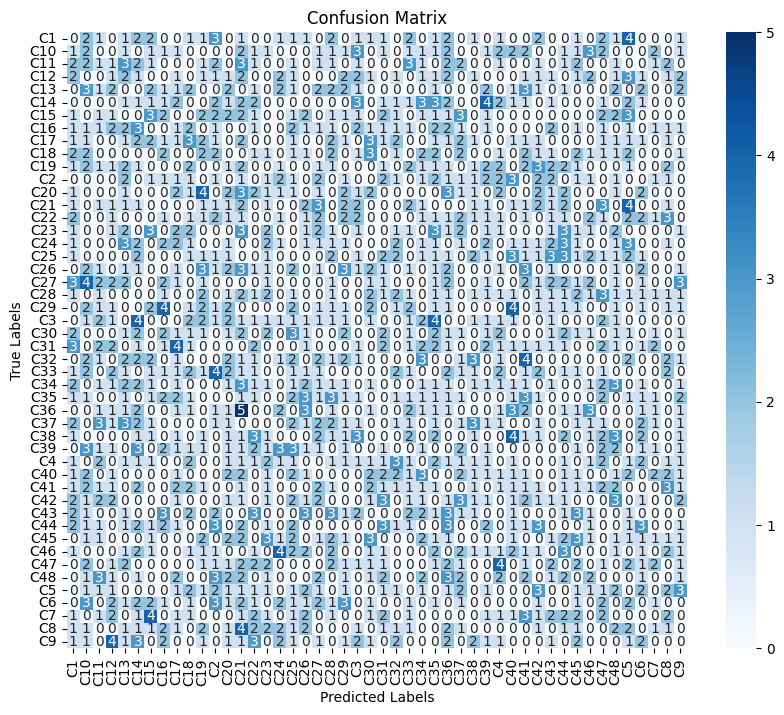

In [12]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
conf_matrix = confusion_matrix(test_true_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_labels, yticklabels=test_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from tensorflow.keras.models import load_model
best_model2 = load_model('/kaggle/working/MNCR_best_model_CH_Loss.h5')

# best model1
test_loss, test_accuracy = best_model2.evaluate(test_ds)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

60/60 [==============================] - 8s 122ms/step - loss: 0.6405 - accuracy: 0.8750
Testing Loss: 0.6404667496681213
Testing Accuracy: 0.875


In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the testing dataset
y_pred = best_model2.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the validation dataset generator
test_true_labels = test_ds.classes

# Convert one-hot encoded labels to class labels
test_class_labels = list(test_ds.class_indices.keys())

# Generate classification report
classification_rep = classification_report(test_true_labels, y_pred_classes, target_names=test_class_labels)

print("Classification Report:")
print(classification_rep)

60/60 [==============================] - 7s 119ms/step
Classification Report:
              precision    recall  f1-score   support

          C1       0.04      0.05      0.05        40
         C10       0.02      0.03      0.02        40
         C11       0.00      0.00      0.00        40
         C12       0.03      0.03      0.03        40
         C13       0.02      0.03      0.02        40
         C14       0.00      0.00      0.00        40
         C15       0.00      0.00      0.00        40
         C16       0.00      0.00      0.00        40
         C17       0.00      0.00      0.00        40
         C18       0.00      0.00      0.00        40
         C19       0.00      0.00      0.00        40
          C2       0.00      0.00      0.00        40
         C20       0.00      0.00      0.00        40
         C21       0.01      0.03      0.02        40
         C22       0.00      0.00      0.00        40
         C23       0.03      0.03      0.03        40
   

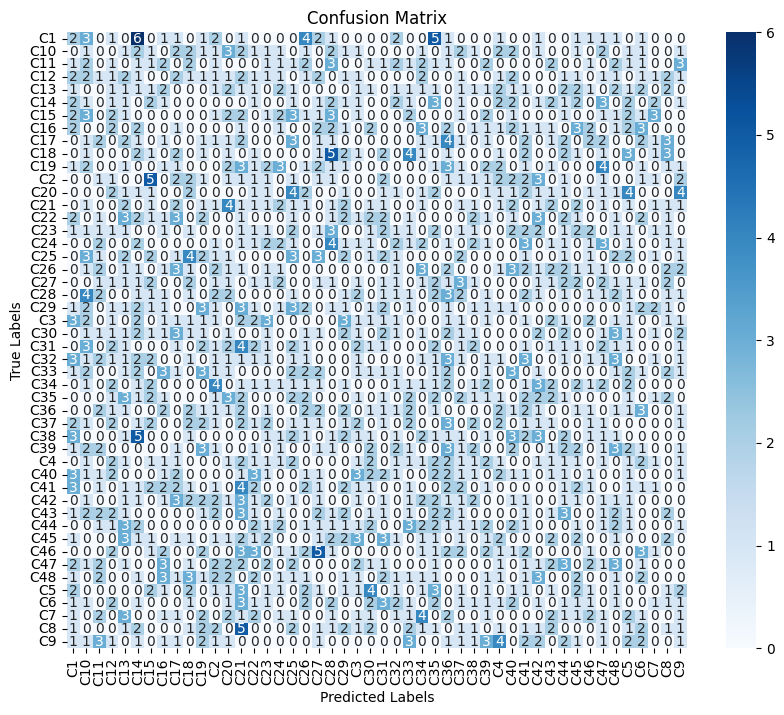

In [15]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Create a confusion matrix
conf_matrix = confusion_matrix(test_true_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_class_labels, yticklabels=test_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()